In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model

In [51]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.pkl.gz')
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [52]:
#my tips:Gauss sampling,sample Z
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


#my tips:loss(restruct X)+KL
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [53]:
batch_size = 1
original_dim = 784   #28*28
latent_dim = 2
intermediate_dim = 256
nb_epoch = 10
epsilon_std = 1.0

In [54]:
#my tips:encoding
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [55]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# my tips:get sample z(encoded)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
 
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [56]:
#This model will include all layers required in the computation of x given x_decoded_mean.
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [57]:
# train the VAE on MNIST digits
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 371s - loss: 10596.6206 - val_loss: 111141.8481
Epoch 2/10
 - 417s - loss: 105026498450.3411 - val_loss: 11645306.8420
Epoch 3/10
 - 398s - loss: nan - val_loss: nan
Epoch 4/10
 - 407s - loss: nan - val_loss: nan
Epoch 5/10
 - 379s - loss: nan - val_loss: nan
Epoch 6/10
 - 395s - loss: nan - val_loss: nan
Epoch 7/10
 - 396s - loss: nan - val_loss: nan
Epoch 8/10
 - 407s - loss: nan - val_loss: nan
Epoch 9/10
 - 397s - loss: nan - val_loss: nan
Epoch 10/10
 - 407s - loss: nan - val_loss: nan


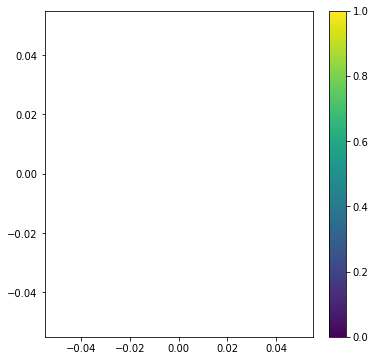

<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\User\Anaconda3\lib\site-packages\numpy\ma\core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


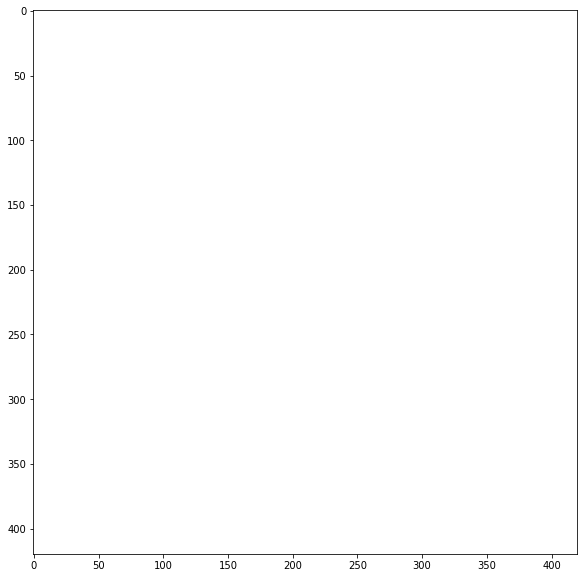

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [59]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
 
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
 
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
 
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
 
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
 
plot_model(vae,to_file='variational_autoencoder_vae.png',show_shapes=True)
plot_model(encoder,to_file='variational_autoencoder_encoder.png',show_shapes=True)
plot_model(generator,to_file='variational_autoencoder_generator.png',show_shapes=True)


In [ ]:
x_test_encoded